In [1]:
import sys
# import pyccl as ccl
import pickle
import camb
sys.path.insert(0,'../scripts')
from importlib import reload
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import default_cosmology
from astropy import units
import astropy
import time

import psutil
from distributed.utils import format_bytes

#only for python3
import importlib
reload=importlib.reload
from Fisher_photoz_functions import *

In [2]:
test=False

Desi=True
Fmost=False

In [3]:
dask_dir=None
Scheduler_file=None

fig_home='./figures/'
fig_format='pdf'
file_home='/verafs/scratch/phy200040p/sukhdeep/physics2/skylens/tests/fisher/'

#redshift bins
z_min=0.1 
z_max=3.5 #max photoz
z_max_galaxy=1.5 #max photoz
zmin=z_min
zmax=z_max

shear_n_zbins=5
galaxy_n_zbins=5
galaxyD_n_zbins={} #galaxyD==DESI
galaxyD_n_zbins_tot=0
if Desi:
    galaxyD_n_zbins['elg']=5
    galaxyD_n_zbins['lrg']=4
    galaxyD_n_zbins['BG']=2
    galaxyD_n_zbins['qso']=6
    galaxyD_n_zbins_tot=np.int(np.sum(list(galaxyD_n_zbins.values())))

nz_shear=26 #galaxy/arcmin^-2
nz_galaxy=3

nz_train_spectra=np.int32(1e6)

train_sample_missed=1
nz_shear_missed=6

nz_shear-=nz_shear_missed
sigma_gamma=0.26

n_zPS=100
z_max_PS=5
z_true_max=z_max_PS
z_PS=np.logspace(np.log10(z_min),np.log10(z_max_PS),50)
z_PS2=np.linspace(z_min,z_max_PS,np.int((z_max_PS-z_min)/.05 ))
z_PS=np.sort(np.unique(np.around(np.append(z_PS,z_PS2),decimals=3)))
n_zPS=len(z_PS)
nz_PS=n_zPS

n_zs_shear=np.int((z_true_max-z_min)/.1)  #this will be nz(or pz) params as well
n_zs_galaxy=np.int((z_true_max-z_min)/.1)


#Cl args
lmax_cl=1000   #[1000,2000,5000]
lmin_cl=20
Nl_bins=12
bin_cl=True #False
use_binned_l=True
do_pseudo_cl=True
l0,l_bins,l=get_cl_ells(lmax_cl=lmax_cl,Nl_bins=Nl_bins,lmin_cl=lmin_cl,bin_cl=bin_cl)
lb=l*1
if bin_cl:
    lb=0.5*(l_bins[1:]+l_bins[:-1])

#xi args
do_xi=False

#window
use_window=do_pseudo_cl
unit_window=False
nside=1024 #32
window_lmax=nside #30

print('doing nside',nside,window_lmax,use_binned_l)
wig_home='/verafs/scratch/phy200040p/sukhdeep/physics2/skylens/'
wig_home=wig_home+'temp/'
wigner_files={}
wigner_files[0]= wig_home+'/dask_wig3j_l3500_w2100_0_reorder.zarr'
wigner_files[2]= wig_home+'/dask_wig3j_l3500_w2100_2_reorder.zarr'

store_win=True
save_win=True

#covariance and area
SSV_cov=False #[False,True]

do_cov=True
sparse_cov=True
tidal_SSV_cov=SSV_cov
Tri_cov=False
do_sample_variance=True

area=15000

area_train=1500
nz_shear_train=nz_train_spectra/area_train/3600 #arcmin^-2

f_sky=area*d2r**2/4/np.pi
f_sky_train=area_train*d2r**2/4/np.pi

#baryons & cosmology
bary_nQ=0   #[0,2,1,3,5]
if bary_nQ>0:
    pk_func='baryon_pk'
else:
    pk_func='camb_pk_too_many_z'
cosmo_parameters=np.atleast_1d(['As','Om','w','wa'])
pk_params={'non_linear':1,'kmax':30,'kmin':3.e-4,'nk':2000,'scenario':'dmo','pk_func':'baryon_pk'}# 'pk_func':'camb_pk_too_many_z'} #baryon_pk
power_spectra_kwargs={'pk_params':pk_params}

corrs=[corr_ggl,corr_gg,corr_ll]

if test:
    lmax_cl=200
    l0,l_bins,l=get_cl_ells(lmax_cl=lmax_cl,Nl_bins=Nl_bins,lmin_cl=lmin_cl,bin_cl=bin_cl)
    shear_n_zbins=2
    galaxy_n_zbins=2
    nside=32
    window_lmax=nside
    if Desi:
        galaxyD_n_zbins['elg']=1
        galaxyD_n_zbins['lrg']=0
        galaxyD_n_zbins['BG']=0
        galaxyD_n_zbins['qso']=0
        galaxyD_n_zbins_tot=np.int(np.sum(list(galaxyD_n_zbins.values())))

WIN={'full':None,'lsst':None}

proc = psutil.Process()
print(format_bytes(proc.memory_info().rss))

fname_out='{ns}_{nsm}_{nl}_{nlD}_nlb{nlb}_lmax{lmax}_z{zmin}-{zmax}_zlmax{zlmax}_bary{bary_nQ}_AT{at}_NT{NT}.pkl'
if bin_cl and use_binned_l:
    fname_out='binnedL_'+fname_out
elif bin_cl and not use_binned_l:
    fname_out='binned_'+fname_out
if use_window and not unit_window:
    fname_out='win'+str(nside)+'_'+fname_out
elif use_window and unit_window:
    fname_out='unit_win'+str(nside)+'_'+fname_out
if SSV_cov:
    fname_out='SSV_'+fname_out

ncpu=5 #multiprocessing.cpu_count()-1
LC,scheduler_info=start_client(Scheduler_file=Scheduler_file,local_directory=dask_dir,ncpu=None,n_workers=ncpu,threads_per_worker=1,
                                  memory_limit='120gb',dashboard_address=8801,processes=True)
client=client_get(scheduler_info=scheduler_info)
print('client: ',client)#,dask_dir,scheduler_info)

fname_out=fname_out.format(ns=shear_n_zbins,nsm=train_sample_missed,nl=galaxy_n_zbins,nlD=galaxyD_n_zbins_tot,
                           nlb=Nl_bins,lmax=lmax_cl,bary_nQ=bary_nQ,
                           zmin=z_min,zmax=z_max,zlmax=z_max_galaxy,at=area_train,NT=nz_train_spectra)
fname_win=file_home+'/win_'+fname_out

Skylens_kwargs=parse_dict(locals())

from Fisher_photoz_functions import * #to prevent some skylens galaxies getting assigned to Skylens_kwargs

# fname='temp/win_D_{ns}{nl}{nlD}.pkl'.format(ns=nbins,nl=galaxy_n_zbins,nlD=n_lensD_bins)
if use_window and store_win:
    fname_out='win_'+fname_out
    try:
#             crash
        with open(fname_win,'rb') as of:
            WIN=pickle.load(of)
        print('window read')
    except Exception as err:
        save_win=True
        print('window not found. Will compute',err)

clean_tracer_window=False
fname_cl=file_home+'/cl_cov_'+fname_out

try:
#         crash
    with open(fname_cl,'rb') as of:
        cl_all=pickle.load(of)
    cl_L=cl_all['cl_L']
    #cl_L_lsst=cl_all['cl_L_lsst']
    z_bins_kwargs=cl_all['z_bins']
    #z_bins_lsst_kwargs=cl_all['z_bins_lsst']
    print('read cl / cov from file: ',fname_cl)
except Exception as err:
    print('cl not found. Will compute',fname_cl,err)
    crash

if sparse_cov:
    cov_p_inv_test1=np.linalg.inv(cl_L['cov'].todense())
    del cov_p_inv_test1,#cov_p_inv_test2

doing nside 1024 1024 True
243.38 MB
Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid8583/
client:  <Client: 'tcp://127.0.0.1:35647' processes=5 threads=5, memory=600.00 GB>
window read
read cl / cov from file:  /verafs/scratch/phy200040p/sukhdeep/physics2/skylens/tests/fisher//cl_cov_win_win1024_binnedL_5_1_5_17_nlb12_lmax1000_z0.1-3.5_zlmax1.5_bary0_AT1500_NT1000000.pkl


In [4]:
area_train2=1500
nz_shear_train2=nz_train_spectra/area_train2/3600 #arcmin^-2
f_sky_train2=area_train2*d2r**2/4/np.pi
shear_zbins_train2=lsst_source_tomo_bins(zmin=zmin,zmax=zmax,n_zs=n_zs_shear,nside=nside,ns0=nz_shear_train,nbins=shear_n_zbins,f_sky=f_sky_train2,
                          z_sigma_power=1,z_sigma=0.05,ztrue_func=ztrue_given_pz_Gaussian,unit_win=unit_window,
                      use_window=use_window,AI=0,AI_z=0,z_true_max=z_true_max)

ns0:  0.18518518518518517
[0.10002    0.10082016 0.10162032 ... 3.49829966 3.49909982 3.49989998] 49 5
source_tomo_bins, zmax 5.0 3.499899979995999 1.1249749949989998
Tracer utils has no tracers
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 273 3071 31.0 10
Window done. Size: 0.0


/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/cov_utils.py:91: RuntimeWarning: invalid value encountered in true_divide
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:115: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary


/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/verafs/home/sukhdeep/.local/lib/python3.8/site-packages/healpy-1.14.0-py3.8-linux-x86_64.egg/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/survey_utils.py:132: RuntimeWarning: invalid value encountered in sqrt


In [24]:
z_bins_kwargs2=copy.deepcopy(z_bins_kwargs)
z_bins_kwargs2['f_sky_train']=f_sky_train2
z_bins_kwargs2['area_train']=area_train2
z_bins_kwargs2['shear_zbins_train']=shear_zbins_train2
zl=shear_zbins_train2[0]['z']

Skylens_kwargs2=copy.deepcopy(Skylens_kwargs)
Skylens_kwargs2['galaxy_zbins']=shear_zbins_train2
Skylens_kwargs2['shear_zbins']=None
Skylens_kwargs2['corrs']=[corr_gg]
Skylens_kwargs2['corr_indxs']={corr_gg:[(i,i) for i in np.arange(Skylens_kwargs2['galaxy_zbins']['n_bins'])]}
Skylens_kwargs2['stack_indxs']=Skylens_kwargs2['corr_indxs']

In [ ]:
kappa_class_test=Skylens(**Skylens_kwargs2)

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/cov_utils.py:91: RuntimeWarning: invalid value encountered in true_divide


cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.005
power spectra baryon_pk
Win gen: step size 81 980 1025.0 5
Window done. Size: 0.0
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.005
power spectra baryon_pk
Win gen: step size 2 11 1025.0 5
Window done. Size: 0.0
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
set binned measure done
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.005
power spectra baryon_pk
Win gen: step size 81 980 1025.0 5
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
set window_cl: cl0,cl_b done 0.7456018924713135
set window_cl: cl done 0.7771086692810059 0.033 0.0
cl+cov bags done 5 15 0.8148643970489502


In [14]:
np.diag(WIN['full']['cl'][corr_gg][(0,0)]['M'])

array([0.19724793, 0.1984571 , 0.20358109, 0.20773857, 0.21085304,
       0.21304916, 0.21474087, 0.21651768, 0.2172925 , 0.2184403 ,
       0.21970736])

In [20]:
WIN['full']['cl'][corr_gg][(0,0)]['M']

array([[ 1.97247926e-01,  1.24780033e-02,  6.04010269e-04,
         1.94477737e-04,  7.92887414e-05,  3.55801849e-05,
         1.71253469e-05,  1.00467679e-05,  5.36690420e-06,
         3.12882996e-06,  1.50384047e-06],
       [ 5.71538951e-03,  1.98457103e-01,  1.09589179e-02,
         5.06120274e-04,  1.71507783e-04,  7.23742867e-05,
         3.38113876e-05,  1.90754865e-05,  9.77118401e-06,
         6.35199976e-06, -9.66718430e-06],
       [ 1.66463415e-04,  4.30309145e-03,  2.03581091e-01,
         8.68647936e-03,  4.35840723e-04,  1.50900915e-04,
         6.64193680e-05,  3.51949619e-05,  1.85715184e-05,
         1.30090197e-05, -2.86243773e-05],
       [ 2.86568964e-05,  1.25325043e-04,  3.33314585e-03,
         2.07738574e-01,  6.94330533e-03,  3.70570449e-04,
         1.42438561e-04,  6.91547673e-05,  3.55233755e-05,
         2.20172153e-05, -4.75003388e-05],
       [ 6.03638261e-06,  2.21287576e-05,  1.05811476e-04,
         2.57750053e-03,  2.10853038e-01,  5.38057892e-03,
  

In [19]:
x=z_bins_kwargs['galaxy_zbins'][0]['window']>-100
x.mean()

0.3636101881663005

In [21]:
hp.anafast(z_bins_kwargs['galaxy_zbins'][0]['window'])

array([1.00000000e+00, 4.05393923e-01, 3.03710056e-02, ...,
       4.30601238e-08, 3.35001505e-08, 1.66568925e-08])

[]

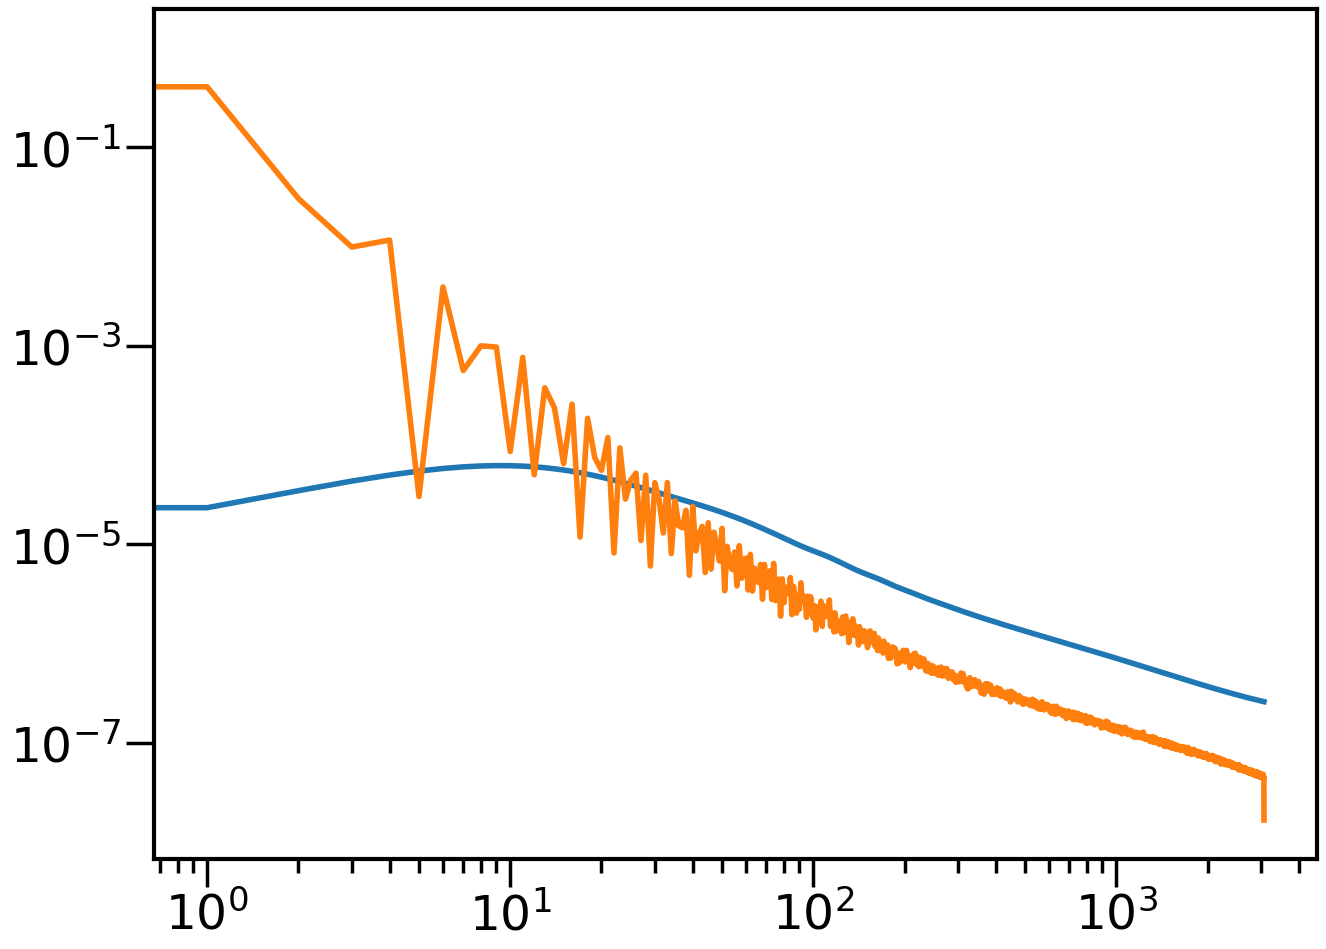

In [22]:
plot(z_bins_kwargs['galaxy_zbins'][0]['window_cl0'])
plot(hp.anafast(z_bins_kwargs['galaxy_zbins'][0]['window']))
loglog()

In [16]:
z_bins_kwargs['galaxy_zbins'][0].keys()

dict_keys(['z', 'dz', 'nz', 'ns', 'W', 'pz', 'pzdz', 'Norm', 'b1', 'bz1', 'AI', 'AI_z', 'mag_fact', 'shear_m_bias', 'lm', 'k_max', 'window_cl0', 'window'])

In [ ]:
kappa_class.Win['cl'].keys()

In [26]:
def photoz_prior2(kappa_class=None,Skylens_kwargs0={},z_bins_kwargs={},key_label={}):
    client=client_get(scheduler_info=Skylens_kwargs0['scheduler_info'])
    window_l=np.arange(Skylens_kwargs0['window_lmax']+1)
    zbins=client.gather(z_bins_kwargs['shear_zbins_train']) #dictionary of z_bins of the training sample, in skylens format
    zl=zbins[0]['z']
    AP2=copy.deepcopy(kappa_class.Ang_PS)
    AP2.z=zl
    AP2.dz=np.gradient(zl)
    AP2.l=window_l
    AP2.reset()
    
    f_sky=z_bins_kwargs['area_train']*d2r**2/4/np.pi
    area_train_arcmin=z_bins_kwargs['area_train']*3600
    Om_w12=4*np.pi*f_sky
    
    sigma_win={}
    
    #following computes cl for each histogram bin, centered on zl.
#     clz=kappa_class2.Ang_PS.angular_power_z() #this is dimensionaless power spectra, normalized with some factors of chi and on ell grid. 
    clz=AP2.angular_power_z()
    cosmo_h=AP2.PS
    cH=cosmo_h.Dh/cosmo_h.efunc(zl)
    kernel=1./cH # missing galaxy bias, add later
    cls=clz['cls'].T*clz['dchi']*kernel**2
    cls=cls.T

    npz=zbins['n_bins']*len(zl)
    pz_var=np.zeros((npz,npz))
    prior={}
    for bi in np.arange(zbins['n_bins']):
        for bj in np.arange(bi,zbins['n_bins']):
#             win_f=kappa_class2.Win['cl'][corr_gg][(bi,bj)][12]['cl']
            win_f=hp.anafast(map1=zbins[bi]['window'],map2=zbins[bj]['window'],lmax=Skylens_kwargs0['window_lmax'])
            for zi in np.arange(len(zl)):
                clij=cls[zi]
                sigma_win=np.dot(win_f*np.gradient(window_l)*(2*window_l+1),clij) #under limber clij is non-zero for zi=zj
                sigma_win/=Om_w12**1 #FIXME: Check norm
#                 print('photoz_prior, win: ',Om_w12,sigma_win)
                for zj in np.arange(len(zl)):
                    var=0
                    if zi==zj:
                        try:
                            pzf=zbins[bi]['pz'][zi]*zbins[bj]['pz'][zj] #some of 'pz'=0 bins are thrown away
                        except:
                            continue
                        var+=sigma_win*pzf
                    if bi==bj and zi==zj: 
                        var+=1*zbins[bi]['pz'][zi]/(zbins[bi]['ns']*area_train_arcmin) #denominator is the total number of galaxies
                        kk=key_label+str(bi)+'_'+str(zj)
                        prior[kk]=np.sqrt(var) #FIXME: this is neglecting cross correlations between bins
                        print('photoz_prior: ',kk,prior[kk],zbins[bi]['pz'][zi],zbins[bi]['ns']*area_train_arcmin,sigma_win*pzf,sigma_win)
                    pz_var[bi*len(zl)+zi,bj*len(zl)+zj]=var
                    pz_var[bj*len(zl)+zj,bi*len(zl)+zi]=var
    prior['var']=pz_var
    return prior


In [ ]:
if globals().get('priors_ana') is None:
    priors_ana={}

In [27]:
priors_ana[area_train2]=photoz_prior2(kappa_class=kappa_class_test,Skylens_kwargs0=Skylens_kwargs2,z_bins_kwargs=z_bins_kwargs2,key_label='nz_s_')

photoz_prior:  nz_s_0_0 0.016845181084299717 0.7828382258070237 215968.26157777497 0.00028013534210210217 0.00045711329755411355
photoz_prior:  nz_s_0_1 0.02093412995279008 2.097399323178191 215968.26157777497 0.0004285261878324943 9.741259669988463e-05
photoz_prior:  nz_s_0_2 0.017954416767285566 2.8876405800373055 215968.26157777497 0.00030899041041616224 3.705601628365986e-05
photoz_prior:  nz_s_0_3 0.012359661043293856 2.752244293407902 215968.26157777497 0.00014001747684704217 1.8484524682353714e-05
photoz_prior:  nz_s_0_4 0.0044296483482896155 1.1508881797807313 215968.26157777497 1.4292815448531873e-05 1.0790747411467955e-05
photoz_prior:  nz_s_0_5 0.0008195818904294941 0.1224497108493028 215968.26157777497 1.0473435519525105e-07 6.985116204411794e-06
photoz_prior:  nz_s_0_6 0.00010750347364226498 0.0024894611464060545 215968.26157777497 3.002001893305237e-11 4.84395674914784e-06
photoz_prior:  nz_s_0_7 6.30299958184447e-06 8.579888059205703e-06 215968.26157777497 2.622996133150

photoz_prior:  nz_s_2_0 0.0 0.0 205568.26701304945 0.0 0.00045540037397844875
photoz_prior:  nz_s_2_1 0.0 0.0 205568.26701304945 0.0 9.706193231299899e-05
photoz_prior:  nz_s_2_2 1.5863019066603578e-07 5.172824570196099e-09 205568.26701304945 9.881728727882794e-22 3.692984010501494e-05
photoz_prior:  nz_s_2_3 3.301564052588817e-06 2.2407419495505896e-06 205568.26701304945 9.247694038386562e-17 1.8418309351155463e-05
photoz_prior:  nz_s_2_4 3.8510352164820074e-05 0.0003046623517662182 205568.26701304945 9.977023392761434e-13 1.074888484218551e-05
photoz_prior:  nz_s_2_5 0.0002563872118098712 0.013261445877767815 205568.26701304945 1.2232496104918677e-09 6.955579706961975e-06
photoz_prior:  nz_s_2_6 0.0010536829169740852 0.19177763781316506 205568.26701304945 1.773330884528479e-07 4.821629636553954e-06
photoz_prior:  nz_s_2_7 0.0028842975862126844 0.9923906603964349 205568.26701304945 3.491624643110188e-06 3.5453752877895904e-06
photoz_prior:  nz_s_2_8 0.0047811550127346185 2.13991284773

photoz_prior:  nz_s_4_0 0.0 0.0 169930.42346051396 0.0 0.0004560198823353234
photoz_prior:  nz_s_4_1 0.0 0.0 169930.42346051396 0.0 9.71466193238186e-05
photoz_prior:  nz_s_4_2 0.0 0.0 169930.42346051396 0.0 3.693809759885387e-05
photoz_prior:  nz_s_4_3 0.0 0.0 169930.42346051396 0.0 1.8411912972291856e-05
photoz_prior:  nz_s_4_4 0.0 0.0 169930.42346051396 0.0 1.0740128766471184e-05
photoz_prior:  nz_s_4_5 0.0 0.0 169930.42346051396 0.0 6.947141895153448e-06
photoz_prior:  nz_s_4_6 0.0 0.0 169930.42346051396 0.0 4.814054636683641e-06
photoz_prior:  nz_s_4_7 7.069832852062782e-08 8.493553598271674e-10 169930.42346051396 2.5528491564603362e-24 3.53872073153072e-06
photoz_prior:  nz_s_4_8 6.907243028172202e-07 8.107381262388971e-08 169930.42346051396 1.7831825967631262e-20 2.7129052322852864e-06
photoz_prior:  nz_s_4_9 5.030766643798577e-06 4.300696570199774e-06 169930.42346051396 3.9770555803142944e-17 2.1502257341577444e-06
photoz_prior:  nz_s_4_10 2.7379304129046786e-05 0.0001273794865

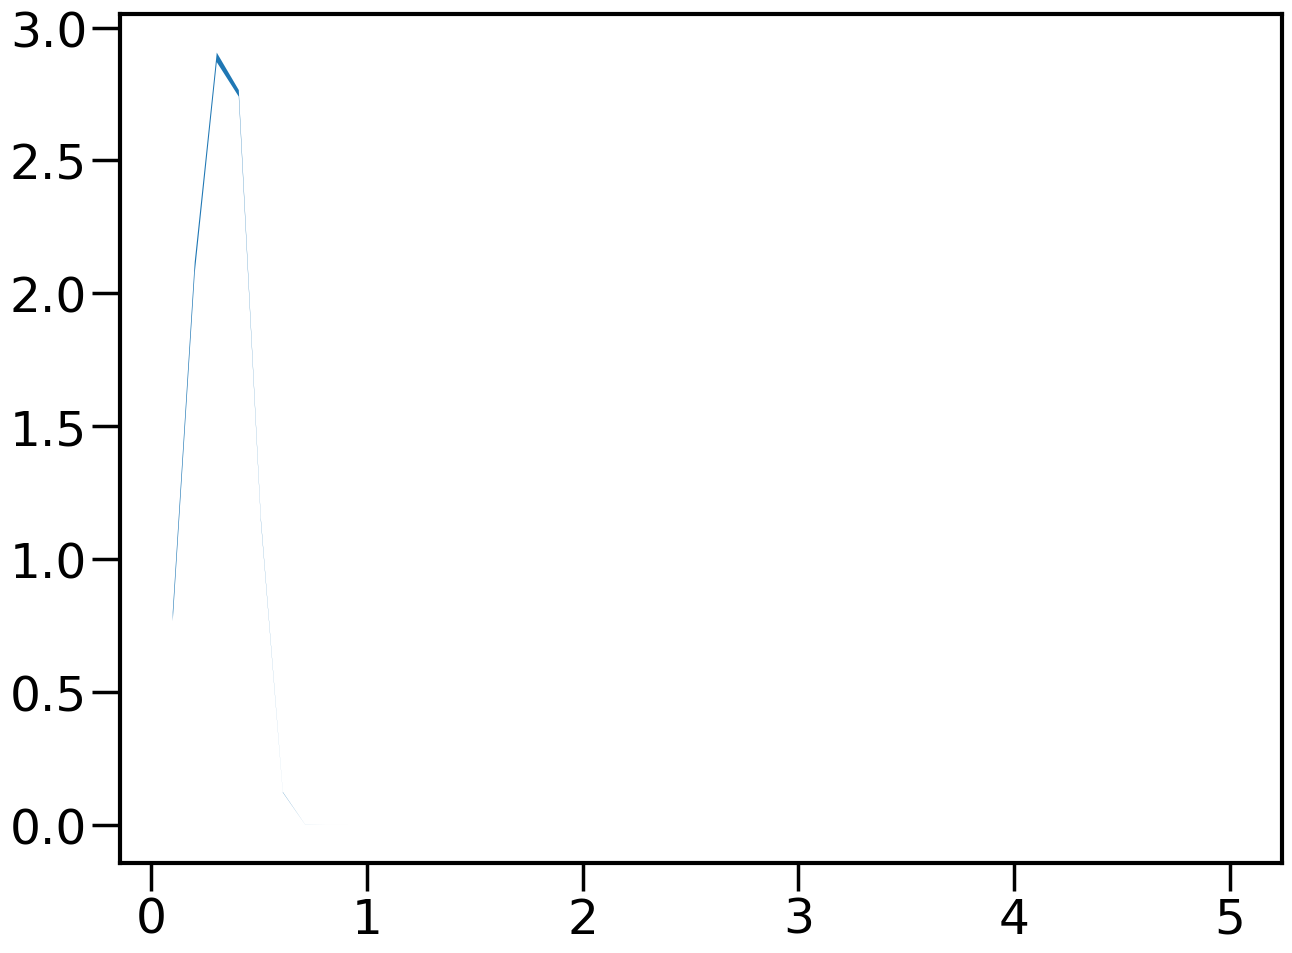

In [28]:
bi=0
pz_err=np.sqrt(np.diag(priors_ana[area_train2]['var']))
len_zl=len(zl)
pz_erri=pz_err[bi*len_zl:(bi+1)*len_zl]
# plot(shear_zbins_train2[bi]['z'],shear_zbins_train2[bi]['pz'])
fill_between(shear_zbins_train2[bi]['z'],shear_zbins_train2[bi]['pz']-pz_erri,shear_zbins_train2[bi]['pz']+pz_erri)

<ipython-input-13-a71fbd7fa5a3>:4: RuntimeWarning: invalid value encountered in true_divide
  corr=priors_ana[at]['var']/np.outer(pz_err,pz_err)


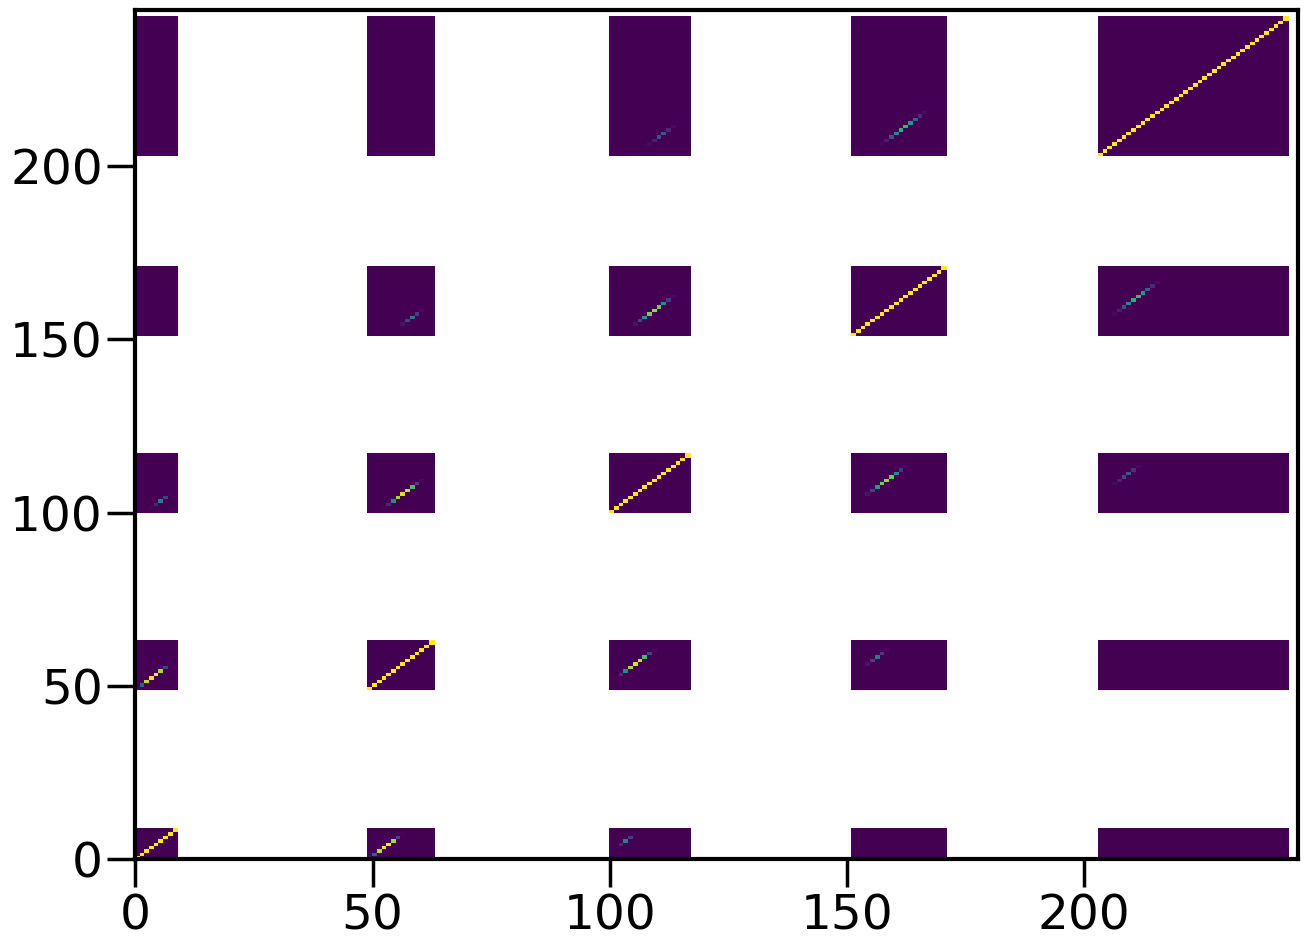

In [13]:
at=150
pz_err=np.sqrt(np.diag(priors_ana[at]['var']))
x=pz_err==0
corr=priors_ana[at]['var']/np.outer(pz_err,pz_err)
pcolor(corr)

Text(3.3, 0.1, 'N spec=1000000')

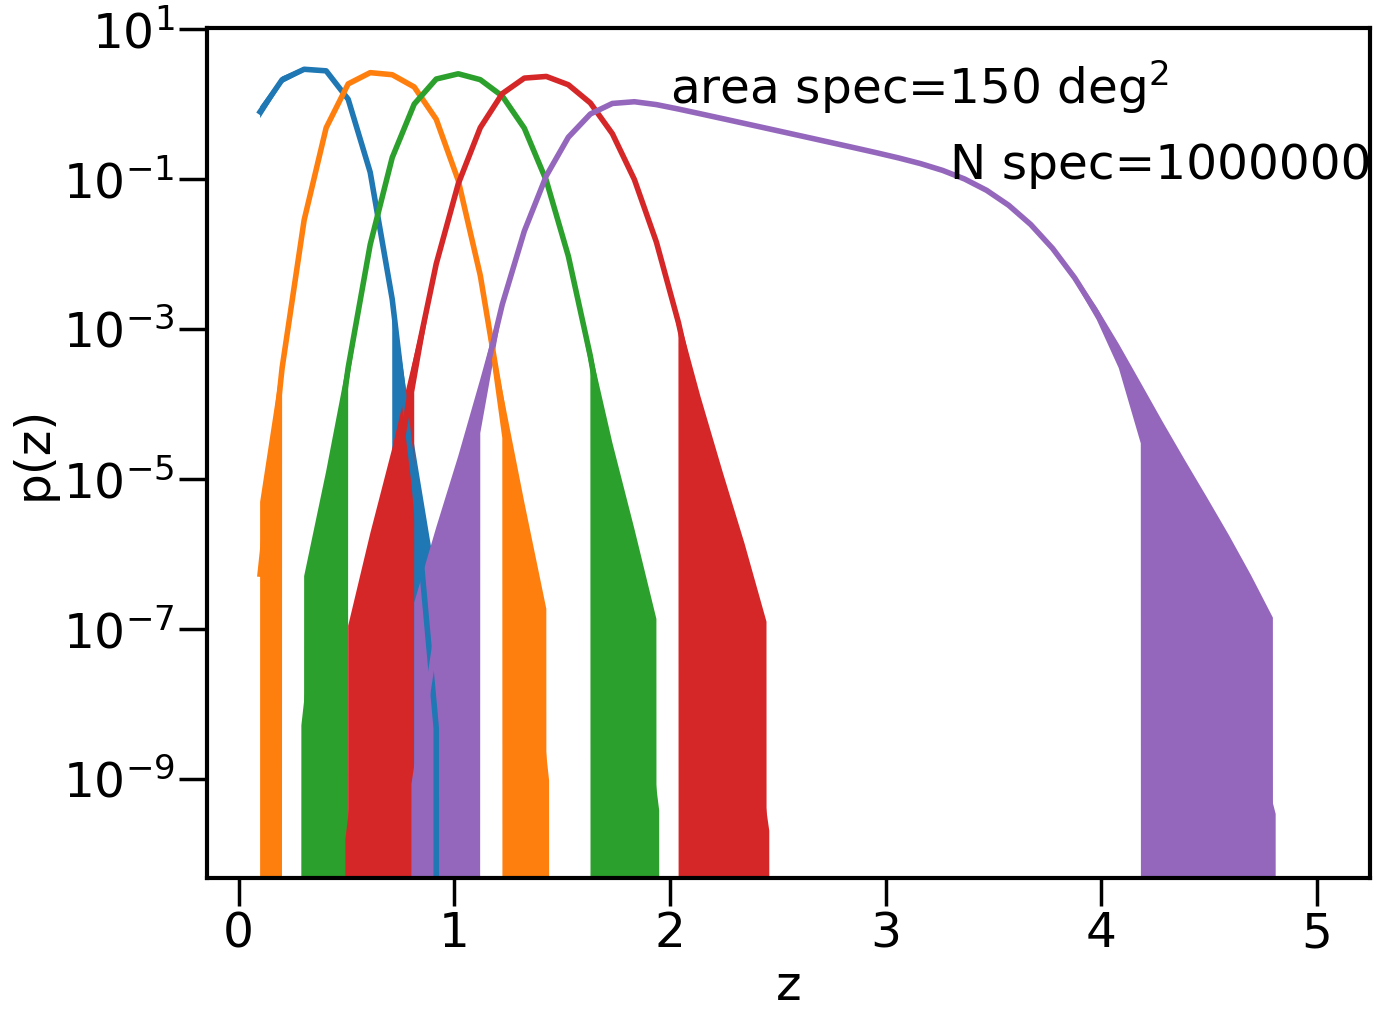

In [21]:
pz_err=np.sqrt(np.diag(priors_ana[area_train2]['var']))
len_zl=len(zl)
for bi in np.arange(shear_zbins_train2['n_bins']):
    pz_erri=pz_err[bi*len_zl:(bi+1)*len_zl]
    plot(shear_zbins_train2[bi]['z'],shear_zbins_train2[bi]['pz'])
    fill_between(shear_zbins_train2[bi]['z'],shear_zbins_train2[bi]['pz']-pz_erri,shear_zbins_train2[bi]['pz']+pz_erri)
yscale('log')
xlabel('z')
ylabel('p(z)')
text(x=2,y=1,s='area spec='+str(area_train2)+ ' deg$^2$')
text(x=3.3,y=.1,s='N spec='+str(nz_train_spectra))

../scripts/Fisher_photoz_functions.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  p=z_bin['nz']*(-0.1*(1+ddz) + 0.12*(1+ddz)**2+.3/np.sqrt(z_bin['ns']*z_bin['nz']))
../scripts/Fisher_photoz_functions.py:1004: RuntimeWarning: invalid value encountered in multiply
  p=z_bin['nz']*(-0.1*(1+ddz) + 0.12*(1+ddz)**2+.3/np.sqrt(z_bin['ns']*z_bin['nz']))
../scripts/Fisher_photoz_functions.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  p=z_bin['nz']*(-0.1*(1+ddz) + 0.12*(1+ddz)**2+.3/np.sqrt(z_bin['ns']*z_bin['nz']))
../scripts/Fisher_photoz_functions.py:1004: RuntimeWarning: invalid value encountered in multiply
  p=z_bin['nz']*(-0.1*(1+ddz) + 0.12*(1+ddz)**2+.3/np.sqrt(z_bin['ns']*z_bin['nz']))
../scripts/Fisher_photoz_functions.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  p=z_bin['nz']*(-0.1*(1+ddz) + 0.12*(1+ddz)**2+.3/np.sqrt(z_bin['ns']*z_bin['nz']))
../scripts/Fisher_photoz_functions.py:1004: RuntimeWarning: invalid value

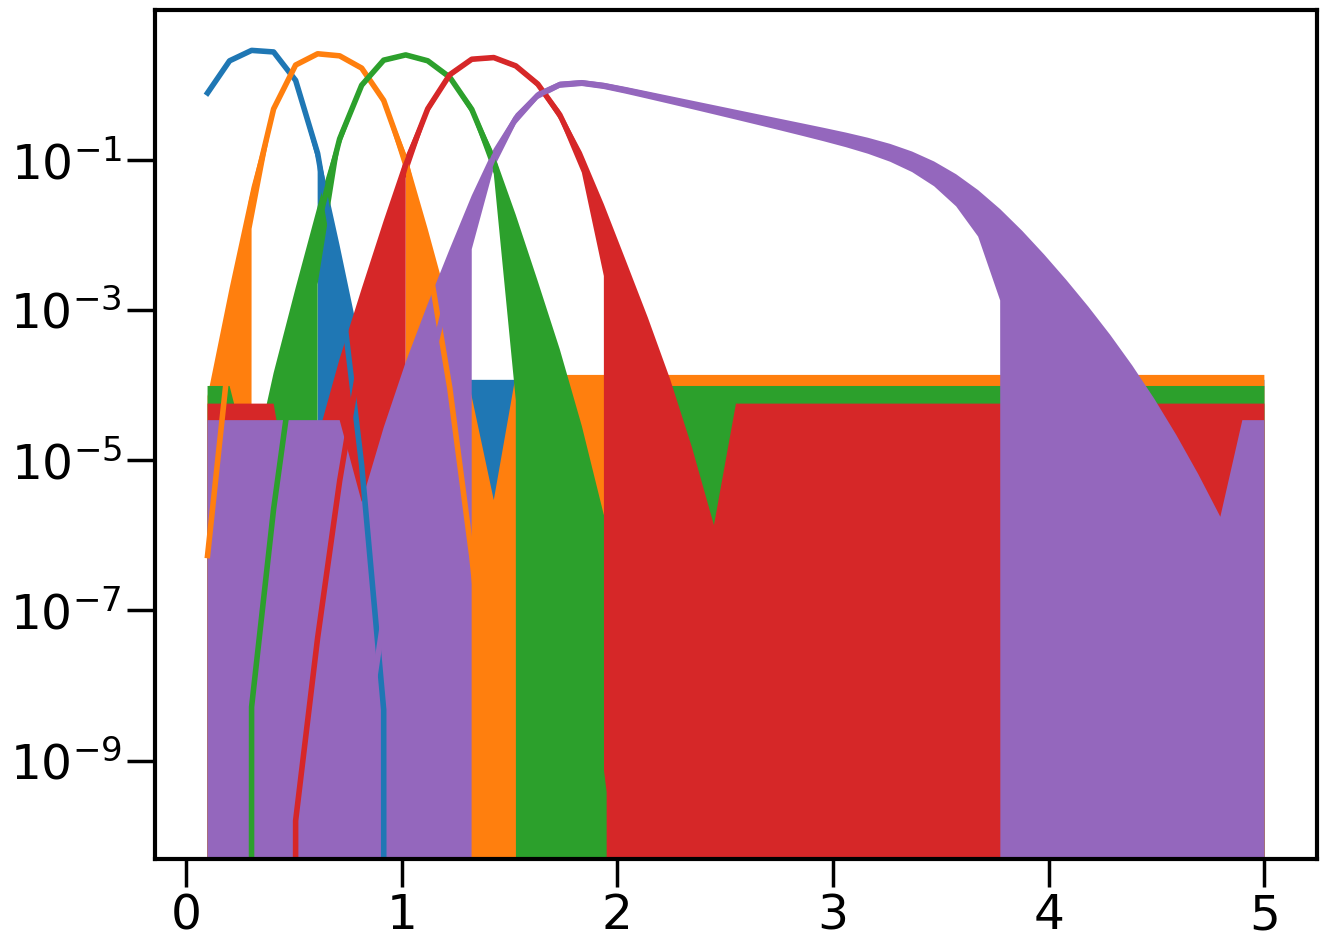

In [133]:
pz_err=np.sqrt(np.diag(priors_ana[area_train2]['var']))
len_zl=len(zl)
for bi in np.arange(shear_zbins_train2['n_bins']):
#     pz_erri=pz_err[bi*len_zl:(bi+1)*len_zl]
    pz_erri=sigma_photoz(z_bin=shear_zbins_train2[bi])
    plot(shear_zbins_train2[bi]['z'],shear_zbins_train2[bi]['pz'])
    fill_between(shear_zbins_train2[bi]['z'],shear_zbins_train2[bi]['pz']-pz_erri,shear_zbins_train2[bi]['pz']+pz_erri)
yscale('log')

../scripts/Fisher_photoz_functions.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  p=z_bin['nz']*(-0.1*(1+ddz) + 0.12*(1+ddz)**2+.3/np.sqrt(z_bin['ns']*z_bin['nz']))
../scripts/Fisher_photoz_functions.py:1004: RuntimeWarning: invalid value encountered in multiply
  p=z_bin['nz']*(-0.1*(1+ddz) + 0.12*(1+ddz)**2+.3/np.sqrt(z_bin['ns']*z_bin['nz']))
../scripts/Fisher_photoz_functions.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  p=z_bin['nz']*(-0.1*(1+ddz) + 0.12*(1+ddz)**2+.3/np.sqrt(z_bin['ns']*z_bin['nz']))
../scripts/Fisher_photoz_functions.py:1004: RuntimeWarning: invalid value encountered in multiply
  p=z_bin['nz']*(-0.1*(1+ddz) + 0.12*(1+ddz)**2+.3/np.sqrt(z_bin['ns']*z_bin['nz']))
../scripts/Fisher_photoz_functions.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  p=z_bin['nz']*(-0.1*(1+ddz) + 0.12*(1+ddz)**2+.3/np.sqrt(z_bin['ns']*z_bin['nz']))
../scripts/Fisher_photoz_functions.py:1004: RuntimeWarning: invalid value

[]

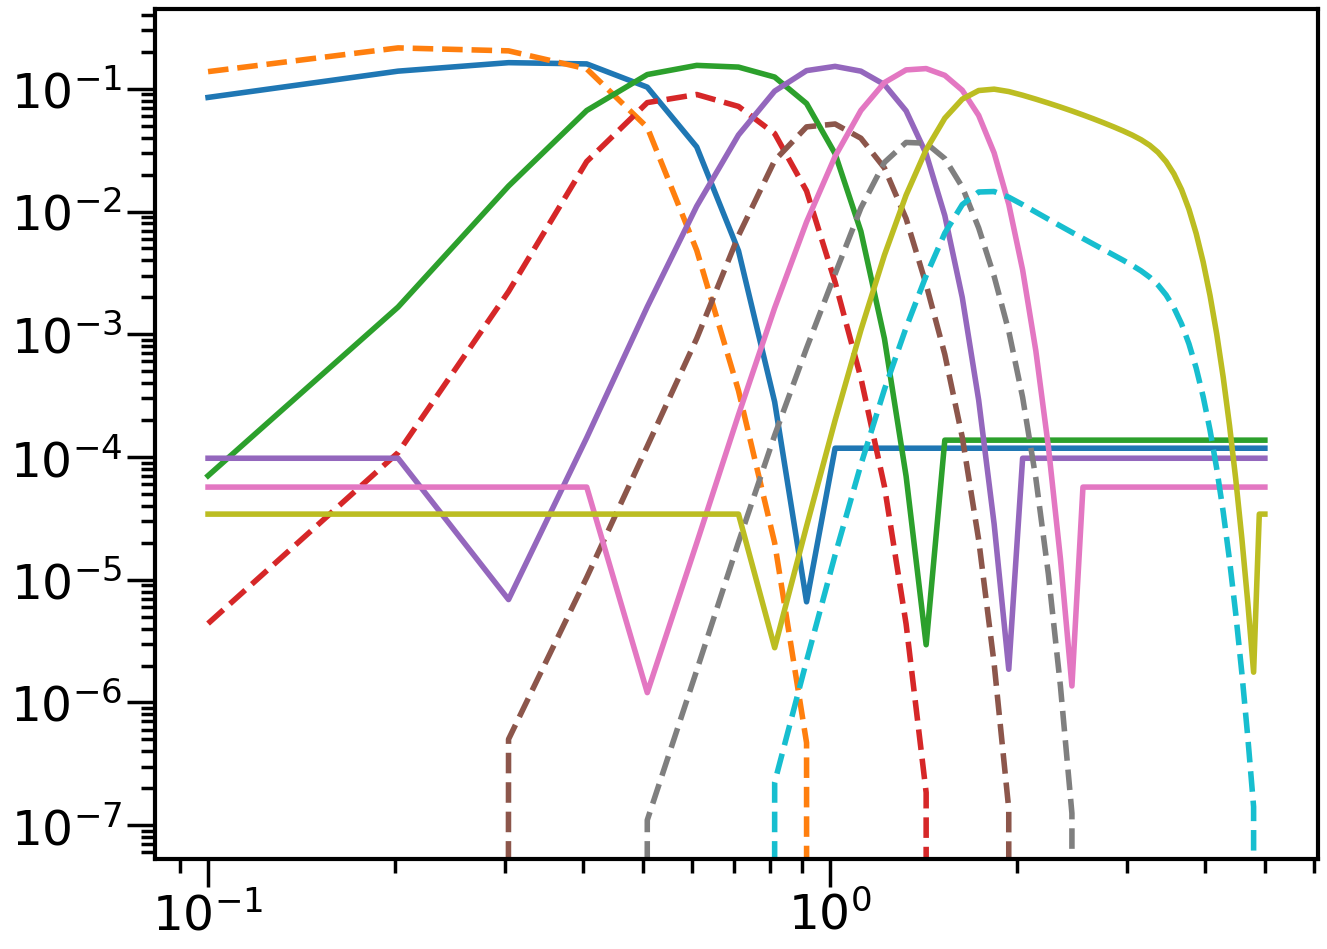

In [134]:
for bi in np.arange(shear_zbins_train2['n_bins']):
    pz_erri=sigma_photoz(z_bin=shear_zbins_train2[bi])
    plot(zl,pz_erri)
    pz_erri=pz_err[bi*len_zl:(bi+1)*len_zl]
    plot(zl,pz_erri,'--')
loglog()

In [30]:
colors=['r','b','g','y','m']

Text(0.71, 0.081, 'Solid: area=1500 deg$^2$')

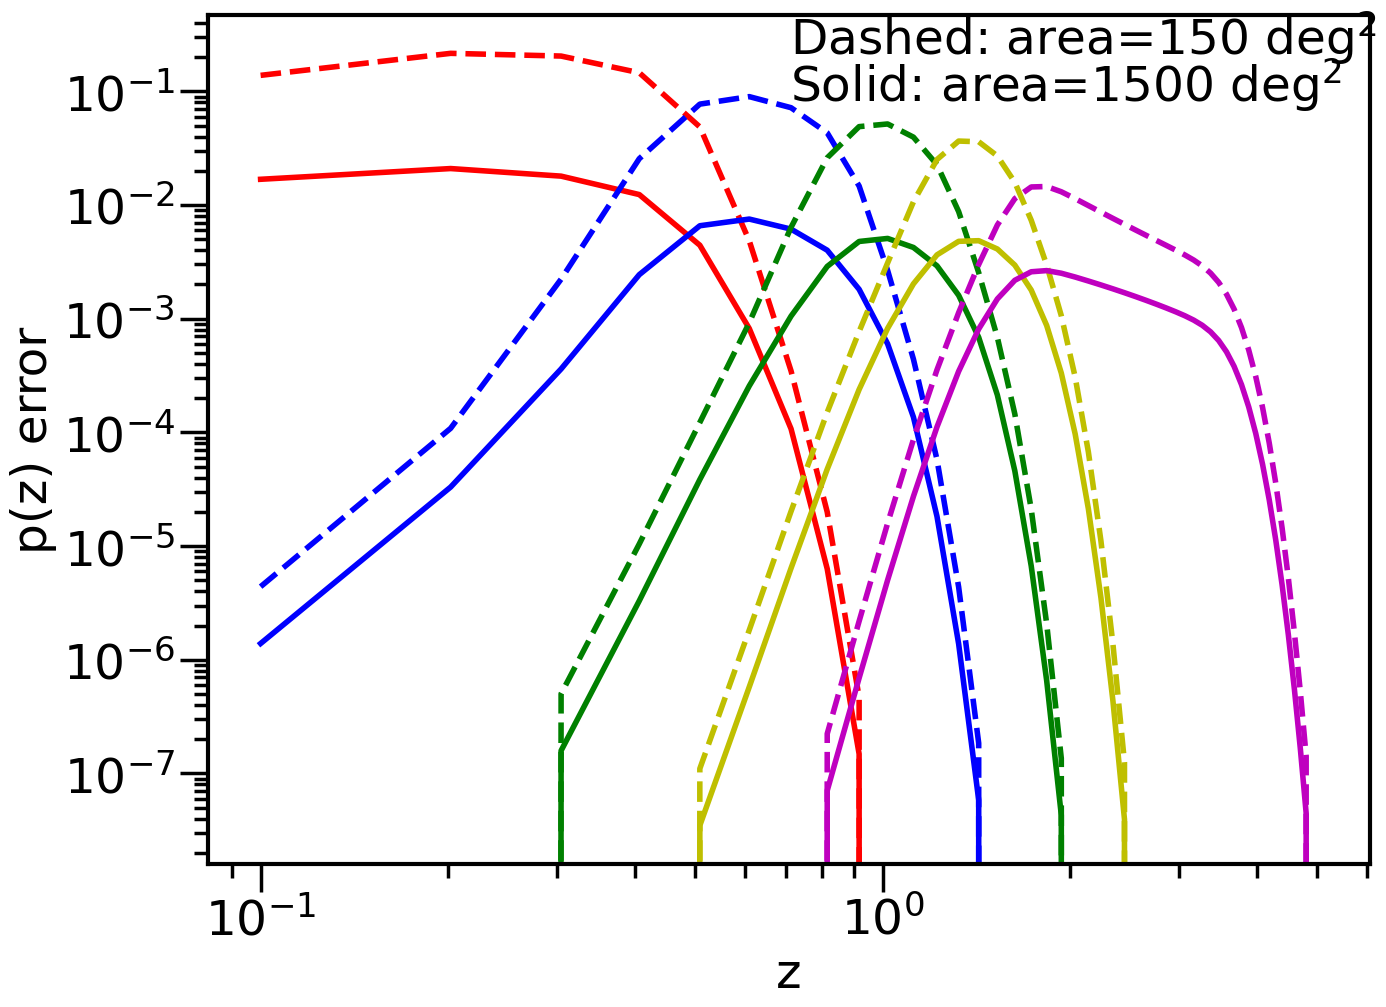

In [36]:
pz_err1=np.sqrt(np.diag(priors_ana[1500]['var']))
pz_err2=np.sqrt(np.diag(priors_ana[150]['var']))
for bi in np.arange(shear_zbins_train2['n_bins']):
    pz_erri=pz_err1[bi*len_zl:(bi+1)*len_zl]
    plot(zl,pz_erri,c=colors[bi])
    pz_erri=pz_err2[bi*len_zl:(bi+1)*len_zl]
    plot(zl,pz_erri,'--',c=colors[bi])
loglog()
xlabel('z')
ylabel('p(z) error')
text(x=.71,y=.21,s='Dashed: area='+str(150)+ ' deg$^2$')
text(x=.71,y=.081,s='Solid: area='+str(1500)+ ' deg$^2$')